In [145]:
import time
import autograd.numpy as np
from autograd.differential_operators import elementwise_grad
from ase.cluster.icosahedron import Icosahedron  ###REMOVE LATER
import pandas as pd
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import seaborn as sns
sns.set_theme()
sns.set(font_scale=1.1, style='ticks')

%matplotlib inline

x0 (5, 2):
[[0.37957598 0.34265905]
 [0.3163907  0.52753602]
 [0.74311778 0.62990274]
 [0.6935785  0.08044958]
 [0.2846676  0.52719993]]
v0 (5, 2):
[[ 1.62627477 -1.5782149 ]
 [ 1.65762596 -0.46377991]
 [-1.93114162  1.35906675]
 [-0.85202385  0.69266597]
 [ 0.76115131 -1.58789358]]


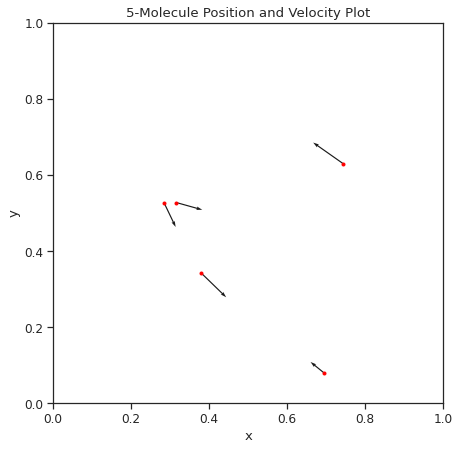

In [184]:
###define constants
K_B = 1.38064852e-23  #Boltzmann constant in [(kg m^2)/(s^2 K)]
RADIUS = 1.  #molecule radius: [5.50483e-10 m], [0.550483 nm], [5.50483 A], [0.4335]
M = 1.  #molecule mass: [4.58574428e-25 kg], [276.16 g/mol], [1]
EPSILON =  1.  #dispersion energy: [4.11814e-20 J], [24.8 kJ/mol], [5.6667 kcal/mol], [0.257027 eV]
TEMP = 1.0*(1/(1.38064852e-23))  #system absolute temperature in [K]

a = np.sqrt((K_B * TEMP) / M)  #for maxwell-boltzmann distribution

###define parameters
size = 1.  #size of system
dim = 2  #number of dimensions for the system (i.e. 1D, 2D, or 3D)
n_molecules = 5  #number of molecules in system
n_steps = 25  #number of Leapfrog steps L per unit time
dt = 1/n_steps  #time step per Leapfrog step
t = 1  #amount of time to simulate in lab-time
u_max = 4e2  #constrain maximum value of potential


###get initial positions and velocities of the n_molecules
def get_initial_xv(dim, size, n_particles, a):
    x0 = np.random.uniform(0, size, size=(n_particles, dim))
    v0 = st.maxwell.rvs(loc=0, scale=a, size=(n_molecules, dim))*np.random.choice([-1,1], size=(n_molecules, dim))
    return x0, v0

x0, v0 = get_initial_xv(dim, size, n_molecules, a)
test = np.random.uniform(0, size, size=(1000, 2))  ### BIG ARRAY FOR TESTING, DELETE ME LATER
print('x0 {}:\n{}'.format(x0.shape, x0[:5]))
print('v0 {}:\n{}'.format(v0.shape, v0[:5]))

fig, ax = plt.subplots(figsize=(7,7))
ax.set(xlim=(0, size), ylim=(0, size),
       title='{}-Molecule Position and Velocity Plot'.format(n_molecules), 
       xlabel='x', ylabel='y')
ax.plot(x0[:,0], x0[:,1], 'o', color='red', markersize=3)
ax.quiver(x0[:,0], x0[:,1], v0[:,0], v0[:,1], color='k', width=0.003, scale_units='xy', scale=25.0)
plt.show()

In [199]:
###define kinetic energy
kinetic = lambda v: 0.5 * M * (v**2).sum()

ke = kinetic(v0)
# grad_ke = M*v0
# print('K: {}'.format(ke))
# print('grad(K):\n{}'.format(grad_ke))

37.6 µs ± 434 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [186]:
###define potential energy
def potential(x, n_molecules, u_max, radius, epsilon):
    rc = 3 * radius
    e0 = 4 * epsilon * ((radius/rc)**12 - (radius/rc)**6)
    a, b = np.triu_indices(n_molecules, 1)  #pairs of indices to compute separation distances
    d = x[a] - x[b]  #sepration vectors
    r2 = (d**2).sum()  #r^2 values
    c6 = np.where(r2 <= rc**2, (radius**2 / r2)**3, np.zeros_like(r2))  #calculate c^6 term
    u = -e0 * (c6 != 0.0).sum()
    c12 = c6**2  #calculate c^12 term
    u += (4 * epsilon * (c12 - c6)).sum()
    return u
grad_potential = elementwise_grad(potential)

ue = potential(x0, n_molecules, u_max, RADIUS, EPSILON) #n_molecules
grad_ue = grad_potential(x0, n_molecules, u_max, RADIUS, EPSILON)
print('U: {}'.format(ue))
print('grad(U):\n{}'.format(grad_ue))

U: -0.49866951163506046
grad(U):
[[-0.68673125 -0.52147892]
 [-1.10439659  0.70058899]
 [ 1.71634122  1.37725021]
 [ 1.38887827 -2.25472767]
 [-1.31409165  0.69836738]]


v(t+dt/2):
[[ 1.61254014 -1.58864447]
 [ 1.63553803 -0.44976813]
 [-1.89681479  1.38661175]
 [-0.82424629  0.64757142]
 [ 0.73486948 -1.57392623]]
x(t+dt):
[[0.44407759 0.27911327]
 [0.38181222 0.5095453 ]
 [0.66724519 0.68536721]
 [0.66060865 0.10635244]
 [0.31406238 0.46424288]]


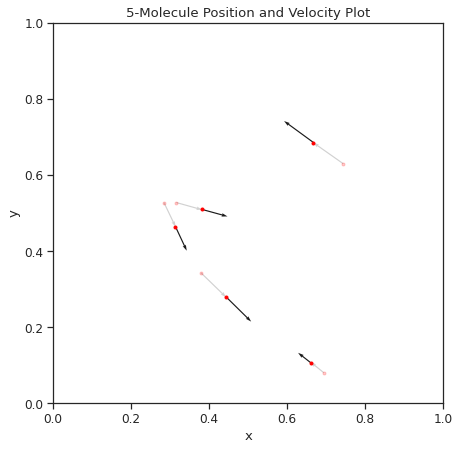

In [187]:
###update velocities by a HALF STEP and positions by a FULL STEP
v = v0 + 0.5 * dt * grad_potential(x0, n_molecules, u_max, RADIUS, EPSILON)
x = x0 + dt * M * v

print('v(t+dt/2):\n{}'.format(v))
print('x(t+dt):\n{}'.format(x))

fig, ax = plt.subplots(figsize=(7,7))
ax.set(xlim=(0, size), ylim=(0, size),
       title='{}-Molecule Position and Velocity Plot'.format(n_molecules), 
       xlabel='x', ylabel='y')
ax.plot(x0[:,0], x0[:,1], 'o', color='red', markersize=3, alpha=0.2)
ax.quiver(x0[:,0], x0[:,1], v0[:,0], v0[:,1], color='k', width=0.003, scale_units='xy', scale=25.0, alpha=0.2)
ax.plot(x[:,0], x[:,1], 'o', color='red', markersize=3)
ax.quiver(x[:,0], x[:,1], v[:,0], v[:,1], color='k', width=0.003, scale_units='xy', scale=25.0)
plt.show()

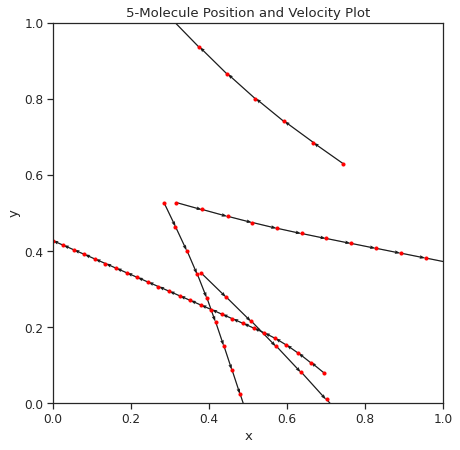

In [194]:
vs = np.zeros((n_molecules, n_steps+1, 2))
xs = np.zeros((n_molecules, n_steps+1, 2))

vs[:,0] = v0
xs[:,0] = x0

###update velocities by a HALF STEP and positions by a FULL STEP
vs[:,1] = v0 + 0.5 * dt * grad_potential(x0, n_molecules, u_max, RADIUS, EPSILON)
xs[:,1] = x0 + dt * M * v

###update velocities by a FULL STEP and positions by a FULL STEP, L-1 times
for i in range(n_steps-1):
    vs[:,i+2] = vs[:,i+1] + dt * grad_potential(xs[:,i+1], n_molecules, u_max, RADIUS, EPSILON)
    xs[:,i+2] = xs[:,i+1] + dt * M * vs[:,i+1]

###overwrite last velocity by a HALF STEP
vs[:,-1] = vs[:,-1] + dt * grad_potential(xs[:,-1], n_molecules, u_max, RADIUS, EPSILON)

fig, ax = plt.subplots(figsize=(7,7))
ax.set(xlim=(0, size), ylim=(0, size),
       title='{}-Molecule Position and Velocity Plot'.format(n_molecules), 
       xlabel='x', ylabel='y')
ax.plot(xs[:,:,0], xs[:,:,1], 'o', color='red', markersize=3, alpha=0.2)
ax.quiver(xs[:,:,0], xs[:,:,1], vs[:,:,0], vs[:,:,1], color='k', 
          width=0.003, scale_units='xy', scale=25.0, alpha=0.2)
ax.plot(xs[:,:,0], xs[:,:,1], 'o', color='red', markersize=3)
ax.quiver(xs[:,:,0], xs[:,:,1], vs[:,:,0], vs[:,:,1], color='k', width=0.003, scale_units='xy', scale=25.0)
plt.show()

In [245]:
x0 = np.array([[1,5]] * 5)

xa = np.array([1,1])
xb = np.array([-3,1])
xc = np.array([1,6])
xd = np.array([4,1])
xe = np.array([1,-3])

print(((x0[0]-xa)**2).sum())
print(((x0[1]-xb)**2).sum())
print(((x0[2]-xc)**2).sum())
print(((x0[3]-xd)**2).sum())
print(((x0[4]-xe)**2).sum())

xz = np.array([[1,1], [-3,1], [1,6], [4,1], [1,-3]])

c = np.min(((x0 - xz)**2).sum(axis=1))

16
32
1
25
64


1